In [1]:
import pandas as pd
import json
import string
import nltk
from wordcloud import WordCloud
import re
from statistics import mean 
import sys

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
sys.path.append("../gather_reviews")
import flipkart_crawler

In [4]:
gathered_reviews_location = flipkart_crawler.save_reviews_for_flipkart_product("https://www.flipkart.com/apple-iphone-6-space-grey-32-gb/product-reviews/itmetmh3hfhnxtcj?pid=MOBETMH3ZYNDPVVC",
                                                  "../data/reviews_received/")

/home/anurag/Repos/ReviewAnalysis/src/gather_reviews/flipkart_crawler.py
/home/anurag/Repos/ReviewAnalysis/src/gather_reviews/parse_specs/flipkart_reviews_html_parse_spec.json
Response code: 200
Number of pages for this product is 50
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from reviews soup 10
Number of reviews from re

In [5]:
def read_json_as_list_of_reviews(file_location:str)-> list:
    with open(file_location, "r") as fr:
        return json.loads(fr.read())

In [6]:
reviews = read_json_as_list_of_reviews(gathered_reviews_location)

In [7]:
print(len(reviews))

500


In [8]:
print(reviews[0])

{'rating': '4', 'title': 'Pretty good', 'review_text': 'best phone and delivered timlyREAD MORE', 'reviewer': 'Tanuj Dhami', 'review_date': 'Tanuj Dhami', 'review_upvotes': '141', 'review_downvotes': '15'}


In [9]:
reviews_df = pd.DataFrame(reviews)
reviews_df.head()

,rating,review_date,review_downvotes,review_text,review_upvotes,reviewer,title
0,4,Tanuj Dhami,15,best phone and delivered timlyREAD MORE,141,Tanuj Dhami,Pretty good
1,5,Intekam Alam,52,Awesome ..READ MORE,352,Intekam Alam,Terrific
2,5,Flipkart Customer,318,good product...READ MORE,1715,Flipkart Customer,Just wow!
3,5,Flipkart Customer,20,the product is very good.. i lov itREAD MORE,150,Flipkart Customer,Must buy!
4,5,Aniket Pongde,90,good productREAD MORE,522,Aniket Pongde,Worth every penny


## Datatype conversion

In [10]:
reviews_df["rating"] = reviews_df["rating"].astype(int)
reviews_df["review_downvotes"] = reviews_df["review_downvotes"].astype(int)
reviews_df["review_upvotes"] = reviews_df["review_upvotes"].astype(int)
reviews_df["review_text"] = reviews_df["review_text"].astype(str)

In [11]:
def get_upvote_to_downvote_ratio(row):
    if row["review_downvotes"] != 0:
        return row["review_upvotes"]/row["review_downvotes"]
    return 0

def get_normalized_rating(row):
    replace_values = {
        0: -2,
        1: -2,
        2: -1,
        3: 0,
        4: 1,
        5: 2
    }
    return replace_values[row["rating"]]

reviews_df["upvote_ratio"] = reviews_df.apply(get_upvote_to_downvote_ratio, axis=1)
reviews_df["normalized_rating"] = reviews_df.apply(get_normalized_rating, axis=1)

In [12]:
reviews_df.head(5)

,rating,review_date,review_downvotes,review_text,review_upvotes,reviewer,title,upvote_ratio,normalized_rating
0,4,Tanuj Dhami,15,best phone and delivered timlyREAD MORE,141,Tanuj Dhami,Pretty good,9.400000,1
1,5,Intekam Alam,52,Awesome ..READ MORE,352,Intekam Alam,Terrific,6.769231,2
2,5,Flipkart Customer,318,good product...READ MORE,1715,Flipkart Customer,Just wow!,5.393082,2
3,5,Flipkart Customer,20,the product is very good.. i lov itREAD MORE,150,Flipkart Customer,Must buy!,7.500000,2
4,5,Aniket Pongde,90,good productREAD MORE,522,Aniket Pongde,Worth every penny,5.800000,2


In [13]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [14]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english'))

def process_review_text(review_obj):
    review_text = review_obj[0]
    
    # replace the read more text
    review_text = review_text.replace("READ MORE", "")
    
    # convert to lower case
    review_text = review_text.lower()
    
    # pattern, replacement, string to update
    review_text = re.sub("[.]+", " ", review_text)
    
    word_tokens = word_tokenize(review_text)
    #print(word_tokens)
    
    stripped_word_tokens = [w.strip() for w in word_tokens]
    word_tokens_no_punctuation = [w for w in stripped_word_tokens if w not in string.punctuation]
    filtered_review = [w for w in word_tokens_no_punctuation if w not in stop_words]
    #print(filtered_review)
    
    # remove all empty words
    filtered_review = [w for w in filtered_review if w]
    
    processed_review_text = " ".join(filtered_review)
    
    # https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
    # review_text.translate(None, string.punctuation)
    # review_text = review_text.translate(review_text.maketrans('', '', string.punctuation))
    return processed_review_text

In [15]:
r = process_review_text(["fabulous phone loved it, cat,dog is pig READ MORE"])
print(r)

fabulous phone loved cat dog pig


In [16]:
reviews_df["processed_review_text"] = reviews_df[["review_text"]].apply(process_review_text, axis=1)
reviews_df["processed_review_text"].head(10)

0                           best phone delivered timly
1                                              awesome
2                                         good product
3                                     product good lov
4                                         good product
5       good one battery backup slightly disappointing
6                     luv❤ phone 's amazing experience
7    purchased bbd 2016 oct 5months use found good/...
8                            's fantastic product love
9    purchased apple iphone 6 good usebut features ...
Name: processed_review_text, dtype: object

In [17]:
all_reviews_concat = " ".join(reviews_df["processed_review_text"].values)
all_reviews_concat[:100]

'best phone delivered timly awesome good product product good lov good product good one battery backu'

In [18]:
def generate_word_cloud_for_reviews(df):
    reviews_concat = " ".join(df["processed_review_text"].values)
    wordcloud = WordCloud().generate(reviews_concat)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    

In [19]:
positive_reviews_df = reviews_df[(reviews_df["rating"] >= 3) & (reviews_df["rating"] <= 5)]
negative_reviews_df = reviews_df[(reviews_df["rating"] >= 0) & (reviews_df["rating"] <= 3)]

In [20]:
total_positive_reviews = positive_reviews_df.shape[0]
total_negative_reviews = negative_reviews_df.shape[0]
total_reviews = reviews_df.shape[0]
print("Positive reviews %: {0} (Ratings from 3-5)".format((total_positive_reviews/total_reviews) * 100))
print("Negative reviews %: {0} (Ratings from 1-3)".format((total_negative_reviews/total_reviews) * 100))

Positive reviews %: 74.0 (Ratings from 3-5)
Negative reviews %: 30.599999999999998 (Ratings from 1-3)


In [21]:
def get_average_upvote_ratio(df):
    df["norma_rtg_x_upv_rto"] = df["normalized_rating"] * df["upvote_ratio"]
    return abs(mean(df["norma_rtg_x_upv_rto"].values))

In [22]:
print("Average upvote ratio for positive reviews {0}".format(get_average_upvote_ratio(positive_reviews_df)))
print("Average upvote ratio for negative reviews {0}".format(get_average_upvote_ratio(negative_reviews_df)))

Average upvote ratio for positive reviews 2.606363590874977
Average upvote ratio for negative reviews 2.2190912585618507


/home/anurag/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


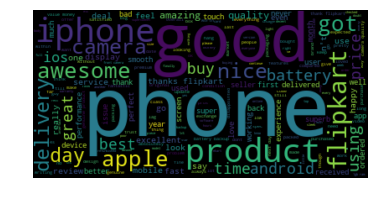

In [23]:
generate_word_cloud_for_reviews(positive_reviews_df)

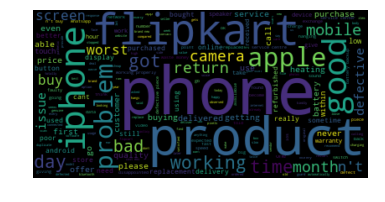

In [24]:
generate_word_cloud_for_reviews(negative_reviews_df)